In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
models=[]
for i in range(10):
    models.append([])
    for j in range(10):
        if i==j:
            name='stochastic_base_models/'+str(i)+'_speckles.h5'
            models[i].append(tf.keras.models.load_model(name))
        else:
            name='stochastic_swapped_models/'+str(i)+'_eigenvectors_'+str(j)+'_SVs.h5'
            models[i].append(tf.keras.models.load_model(name))

In [3]:
(xfr,yfr),(xfe,yfe)=tf.keras.datasets.fashion_mnist.load_data()
(xnr,ynr),(xne,yne)=tf.keras.datasets.mnist.load_data()
(xc10r,yc10r),(xc10e,yc10e)=tf.keras.datasets.cifar10.load_data()
(xc100r,yc100r),(xc100e,yc100e)=tf.keras.datasets.cifar100.load_data()

169009152/169001437 [==============================] - 5s 0us/step


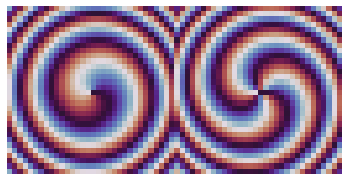

In [8]:
m1 = 1 ; m2 = 3

xmax = 10
dim = 32
dx = 2*xmax/dim ; x = np.linspace(-xmax,xmax-dx,dim)

X,Y=np.meshgrid(x,x)
R2=(X**2+Y**2)
flambda=80
Lens = np.exp(-1j*R2/(flambda/10))


T = np.arctan2(Y,X)
V1 = np.exp(1j*(m1)*T) ; V2 = np.exp(1j*(m2)*T)
LG1=Lens*V1 ; LG2=Lens*V2
plt.imshow(np.angle(np.hstack((LG1,LG2))),cmap='twilight')
plt.axis('off')
plt.show()


def vort_THIS(A,LGA,LGB):
    length=A.shape[0]
    out=np.zeros((length,A.shape[1],A.shape[2]*2))
    for i in range(length):
        A1=A[i]/255
        A1=np.abs(myfft2(np.exp(1j*A1*np.pi/2)*LGA)) ; A2=np.abs(myfft2(np.exp(1j*A1*np.pi/2)*LGB))
        A1=(A1-np.amin(A1))/np.amax(A1-np.amin(A1))*2-1    ; A2=(A2-np.amin(A2))/np.amax(A2-np.amin(A2))*2-1
        #A1=A1/np.sum(A1)
        out[i]=np.hstack((A1,A2))
    return out
def vort_THIS_3chan(A,LGA,LGB):
    length=A.shape[0]
    out=np.zeros((length,A.shape[1],A.shape[2]*2,3))
    for i in range(length):
        A1=A[i,:,:,0]/255
        A1=np.abs(myfft2(np.exp(1j*A1*np.pi/2)*LGA)) ; A2=np.abs(myfft2(np.exp(1j*A1*np.pi/2)*LGB))
        A1=(A1-np.amin(A1))/np.amax(A1-np.amin(A1))*2-1    ; A2=(A2-np.amin(A2))/np.amax(A2-np.amin(A2))*2-1
        #A1=A1/np.sum(A1)
        out[i,:,:,0]=np.hstack((A1,A2))
        A1=A[i,:,:,1]/255
        A1=np.abs(myfft2(np.exp(1j*A1*np.pi/2)*LGA)) ; A2=np.abs(myfft2(np.exp(1j*A1*np.pi/2)*LGB))
        A1=(A1-np.amin(A1))/np.amax(A1-np.amin(A1))*2-1    ; A2=(A2-np.amin(A2))/np.amax(A2-np.amin(A2))*2-1
        #A1=A1/np.sum(A1)
        out[i,:,:,1]=np.hstack((A1,A2))
        A1=A[i,:,:,2]/255
        A1=np.abs(myfft2(np.exp(1j*A1*np.pi/2)*LGA)) ; A2=np.abs(myfft2(np.exp(1j*A1*np.pi/2)*LGB))
        A1=(A1-np.amin(A1))/np.amax(A1-np.amin(A1))*2-1    ; A2=(A2-np.amin(A2))/np.amax(A2-np.amin(A2))*2-1
        #A1=A1/np.sum(A1)
        out[i,:,:,2]=np.hstack((A1,A2))
    return out

In [9]:
xnr_n=np.zeros((60000,32,32))
xfr_n=np.zeros((60000,32,32))
#for i in range(60000):
xnr_n[:,2:30,2:30]=xnr
xfr_n[:,2:30,2:30]=xfr
    

In [10]:
def myfft2(A): 
    return np.fft.fftshift(np.fft.fft2(np.fft.fftshift(A)))
def myifft2(A): 
    return np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(A)))
from skimage.metrics import structural_similarity as ssim
transformed_xfr=vort_THIS(xfr_n,LG1,LG2)
transformed_xnr=vort_THIS(xnr_n,LG1,LG2)
transformed_xc10r=vort_THIS_3chan(xc10r,LG1,LG2)
transformed_xc100r=vort_THIS_3chan(xc100r,LG1,LG2)

In [13]:
# Creates a 2-layer (linear-softmax) NN
# Loss is categorical crossentropy
# This isn't meant to be a 'good' classifier, 
# it is meant to be bad enough so that if an image
# is not salient, accuracy goes to zero.

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras
def classifier(num_classes,input_dimen):
    model = Sequential()
    model.add(Dense(input_dimen, input_dim= input_dimen, activation='linear', use_bias=False))  
    model.add(Dense(num_classes, input_dim= input_dimen, kernel_initializer='normal', activation='softmax', use_bias=False))
    model.compile(loss='CategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [14]:
# Take categorical data and make it understandable by the NN

yfr=tf.keras.utils.to_categorical(yfr)
ynr=tf.keras.utils.to_categorical(ynr)
yc10r=tf.keras.utils.to_categorical(yc10r)
yc100r=tf.keras.utils.to_categorical(yc100r)

In [28]:
# Classifies each image. Saves final validation accuracy
# This takes FOREVER

num_classifier_acc=np.zeros((10,10))
fas_classifier_acc=np.zeros((10,10))
c10_classifier_acc=np.zeros((10,10))
c100classifier_acc=np.zeros((10,10))
for i in range(10):
    for j in range(10):
        print(i,j)
        recon_xnumr=models[i][j].predict(transformed_xnr.reshape(60000,2*32**2)).reshape(60000,32,32)
        model=classifier(10,32**2)
        his=model.fit(recon_xnumr.reshape(60000,32**2),ynr,epochs=100,verbose=0)
        filename='classified_models/MNIST/'+str(i)+'_eigs_'+str(j)+'SVs.h5'
        model.save(filename)
        num_classifier_acc[i,j]=his.history['accuracy'][-1]
        print('mnist done')
        
        recon_xfasr=models[i][j].predict(transformed_xfr.reshape(60000,2*32**2)).reshape(60000,32,32)
        model=classifier(10,32**2)
        his=model.fit(recon_xfasr.reshape(60000,32**2),yfr,epochs=100,verbose=0)
        filename='classified_models/Fashion/'+str(i)+'_eigs_'+str(j)+'SVs.h5'
        model.save(filename)
        fas_classifier_acc[i,j]=his.history['accuracy'][-1]
        print('fash done')
        
        recon_xc10r=np.zeros((50000,32,32,3))
        recon_xc10r[:,:,:,0]=models[i][j].predict(transformed_xc10r[:,:,:,0].reshape(50000,2*32**2)).reshape(50000,32,32)
        recon_xc10r[:,:,:,1]=models[i][j].predict(transformed_xc10r[:,:,:,1].reshape(50000,2*32**2)).reshape(50000,32,32)
        recon_xc10r[:,:,:,2]=models[i][j].predict(transformed_xc10r[:,:,:,2].reshape(50000,2*32**2)).reshape(50000,32,32)
        model=classifier(10,3*32**2)
        his=model.fit(recon_xc10r.reshape(50000,3*32**2),yc10r,epochs=100,verbose=0)
        filename='classified_models/CiFAR_10/'+str(i)+'_eigs_'+str(j)+'SVs.h5'
        model.save(filename)
        c10_classifier_acc[i,j]=his.history['accuracy'][-1]
        print('10 done')
        
        recon_xc100r=np.zeros((50000,32,32,3))
        recon_xc100r[:,:,:,0]=models[i][j].predict(transformed_xc100r[:,:,:,0].reshape(50000,2*32**2)).reshape(50000,32,32)
        recon_xc100r[:,:,:,1]=models[i][j].predict(transformed_xc100r[:,:,:,1].reshape(50000,2*32**2)).reshape(50000,32,32)
        recon_xc100r[:,:,:,2]=models[i][j].predict(transformed_xc100r[:,:,:,2].reshape(50000,2*32**2)).reshape(50000,32,32)
        model=classifier(100,3*32**2)
        his=model.fit(recon_xc100r.reshape(50000,3*32**2),yc100r,epochs=100,verbose=0)
        filename='classified_models/CiFAR_100/'+str(i)+'_eigs_'+str(j)+'SVs.h5'
        model.save(filename)
        c100classifier_acc[i,j]=his.history['accuracy'][-1]
        print('100 done')

0 0
mnist done
fash done
10 done
100 done
0 1
mnist done
fash done
10 done
100 done
0 2
mnist done
fash done
10 done
100 done
0 3
mnist done
fash done
10 done
100 done
0 4
mnist done
fash done
10 done
100 done
0 5
mnist done
fash done
10 done
100 done
0 6
mnist done
fash done
10 done
100 done
0 7
mnist done
fash done
10 done
100 done
0 8
mnist done
fash done
10 done
100 done
0 9
mnist done
fash done
10 done
100 done
1 0
mnist done
fash done
10 done
100 done
1 1
mnist done
fash done
10 done
100 done
1 2
mnist done
fash done
10 done
100 done
1 3
mnist done
fash done
10 done
100 done
1 4
mnist done
fash done
10 done
100 done
1 5
mnist done
fash done
10 done
100 done
1 6
mnist done
fash done
10 done
100 done
1 7
mnist done
fash done
10 done
100 done
1 8
mnist done
fash done
10 done
100 done
1 9
mnist done
fash done
10 done
100 done
2 0
mnist done
fash done
10 done
100 done
2 1
mnist done
fash done
10 done
100 done
2 2
mnist done
fash done
10 done
100 done
2 3
mnist done
fash done
10 done
1

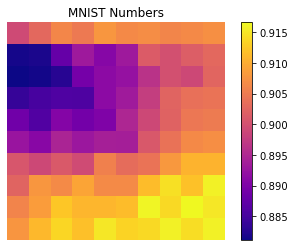

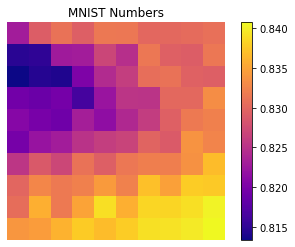

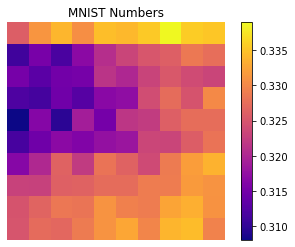

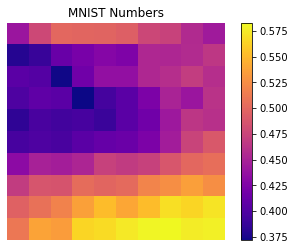

In [34]:
# plot the accuracies in a square matrix

plt.imshow(num_classifier_acc,cmap='plasma')
plt.axis('off')
plt.title('MNIST Numbers')
plt.colorbar()
plt.show()
plt.imshow(fas_classifier_acc,cmap='plasma')
plt.axis('off')
plt.title('MNIST Numbers')
plt.colorbar()
plt.show()
plt.imshow(c10_classifier_acc,cmap='plasma')
plt.axis('off')
plt.title('MNIST Numbers')
plt.colorbar()
plt.show()
plt.imshow(c100classifier_acc,cmap='plasma')
plt.axis('off')
plt.title('MNIST Numbers')
plt.colorbar()
plt.show()